# Dirichlet Process


## dataset

3가지 클러스터를 갖는 2차원 input데이터를 생성한다

In [1]:
import numpy as np
from sklearn import datasets
data_x, data_y = datasets.make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=0.5)
axis_min = np.min(data_x)-1
axis_max = np.max(data_x)+1

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


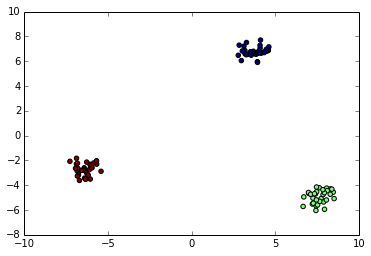

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(data_x[:,0], data_x[:,1], c=data_y)
plt.show()

## Cluster class

In [117]:
from numpy import random
class Cluster(object):
    def __init__(self, initial_datas=None, color=None):
        self.color = color if color else random.rand(3)
        self.assigned = initial_datas
        self.update()
        
    def __len__(self):
        return self._count
    
    def __str__(self):
        mu, cov = self.params()
        return 'mean:%s, cov:%s, members:%d'%(str(mu), str(cov.reshape((1,-1))), self.__len__())
        
    def params(self):
        return self._params
    
    def update(self):
        self._count = len(self.assigned)
        if self._count == 1:
            mu = np.array(self.assigned).mean(axis=0)
            cov = np.eye(mu.size) * 10.0
        else:
            mu = np.array(self.assigned).mean(axis=0)
            cov = np.cov(self.assigned, rowvar=False)
        self._params = mu, cov

    def probability(self, point):
        mu, cov = self.params()
        from scipy.stats import multivariate_normal
        return min([1, multivariate_normal.pdf(point, mean=mu, cov=cov, allow_singular=True)])
    
    def plot(self, ax=None, **kwargs):
        if self.__len__() < 1:
            return
        from matplotlib.patches import Ellipse
        def eigsorted(cov):
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            return vals[order], vecs[:,order]
        if ax is None:
            ax = plt.gca()
        mu, cov = self.params()
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        
        p = self.probability(mu)
        for nstd in range(1, 6):
            width, height = 2.0 * nstd * np.sqrt(vals)
            ellipse = Ellipse(xy=mu, width=width, height=height, angle=theta, **kwargs)
            ax.add_artist( ellipse )
            ellipse.set_alpha( p * 0.1 )
            ellipse.set_facecolor(self.color)


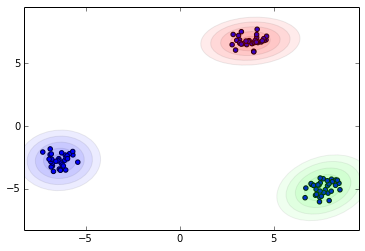

mean:[ 3.75544241  6.76037771], cov:[[ 0.2776782   0.02268258  0.02268258  0.14617324]], members:34
mean:[ 7.61895435 -4.91995507], cov:[[ 0.24183757  0.06952576  0.06952576  0.27460097]], members:33
mean:[-6.36638007 -2.73632762], cov:[[ 0.1877296   0.00745236  0.00745236  0.23266763]], members:33


In [118]:
gt_clusters = [Cluster([data_x[i,:] for i, v in enumerate(data_y) if v==0], [1, 0, 0] ),
            Cluster(np.array([data_x[i,:] for i, v in enumerate(data_y) if v==1]), [0, 1, 0] ),
            Cluster(np.array([data_x[i,:] for i, v in enumerate(data_y) if v==2]), [0, 0, 1] ) ]

fig = plt.figure(0)
ax = fig.add_subplot(111)
[c.plot(ax) for c in gt_clusters]
ax.scatter(data_x[:,0], data_x[:,1])
plt.axis([axis_min, axis_max, axis_min, axis_max])
plt.show()

for c in gt_clusters:
    print c

## Dirichlet Process (CRP)

In [119]:
def assigne(data, N, clusters, alpha=5.0):
    assigne_probability = [c.probability(data) * len(c) / ( N-1.0+alpha ) for c in clusters]
    assigne_probability += [max(assigne_probability) * alpha / ( N-1.0+alpha )] # create probability
    assigne_probability = [p/sum(assigne_probability) for p in assigne_probability]
    cummulative_probability = [0.0]
    for i, p in enumerate(assigne_probability):
        cummulative_probability.append( cummulative_probability[-1] + p )
    
    sample_y = np.random.uniform()
    cluster_idx = [i for i, p in enumerate(cummulative_probability[:-1]) if p<=sample_y and sample_y<=cummulative_probability[i+1] ][0]
    return cluster_idx

#clusters: 100


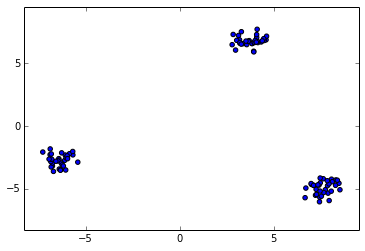

In [120]:
# initialize
clusters = [Cluster([data]) for data in data_x]
cluster_idxs = [i for i, data in enumerate(data_x)]
print '#clusters: %d'%len(clusters)

fig = plt.figure(0)
ax = fig.add_subplot(111)
[c.plot(ax) for c in clusters]
ax.scatter(data_x[:,0], data_x[:,1])
plt.axis([axis_min, axis_max, axis_min, axis_max])
plt.show()


alpha:1.000000 #clusters: 13


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in sqrt


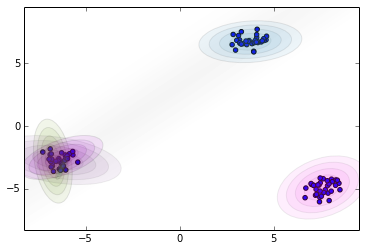

mean:[ 8.45961293 -4.56152579], cov:[[ 10.   0.   0.  10.]], members:1
mean:[ 7.58150901 -4.89859043], cov:[[ 0.22953781  0.07583643  0.07583643  0.25342378]], members:31
mean:[ 3.75531026  6.71571922], cov:[[ 0.2988961   0.02546554  0.02546554  0.11122915]], members:30
mean:[-6.39388499 -3.4298493 ], cov:[[ 10.   0.   0.  10.]], members:1
mean:[-5.99837733 -2.53622645], cov:[[  2.60658847e-03  -4.70608521e-04  -4.70608521e-04   8.49663775e-05]], members:2
mean:[-6.73521585 -2.79776429], cov:[[ 0.0425135  -0.03996014 -0.03996014  0.44765557]], members:5
mean:[-6.26190034 -2.50412518], cov:[[ 0.19126277  0.08513226  0.08513226  0.12227017]], members:11
mean:[-6.33404195 -3.52590522], cov:[[ 10.   0.   0.  10.]], members:1
mean:[-6.23998591 -3.25047341], cov:[[ 0.00448893  0.01039976  0.01039976  0.03986274]], members:3
mean:[ 1.74566329 -0.15498062], cov:[[ 58.64707305   0.27294954   0.27294954  49.77322996]], members:3
mean:[-6.47130159 -2.71289102], cov:[[ 0.45356722 -0.08990195 -0.08

In [141]:
alpha=1.0
for i, data in enumerate(data_x):
    new_clusters = []
    for idx in range(max(cluster_idxs)+1):
        samples = [data_x[k,:] for k, v in enumerate(cluster_idxs) if v==idx and k!=i]
        if len(samples)>0:
            new_clusters.append( Cluster(samples) )
            
    index = assigne(data, len(data_x), new_clusters)
    cluster_idxs[i] = index
    
clusters = []
for idx in range(max(cluster_idxs)+1):
    samples = [data_x[k,:] for k, v in enumerate(cluster_idxs) if v==idx]
    if len(samples)>0:
        clusters.append( Cluster(samples) )

print 'alpha:%f #clusters: %d'%(alpha, len(clusters))

fig = plt.figure(0)
ax = fig.add_subplot(111)
[c.plot(ax) for c in clusters]
ax.scatter(data_x[:,0], data_x[:,1])
plt.axis([axis_min, axis_max, axis_min, axis_max])
plt.show()

for c in clusters:
    print c
